In [1]:
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [24]:
df = pd.read_csv('../data/new/albums_final.csv')

In [6]:
def train_album_classifier(df, img_dir, popularity_threshold=55, image_size=(64, 64), batch_size=32, epochs=50):
    # 1. Bin popularity into binary class
    df = df.copy()
    df['popularity_class'] = df['popularity'].apply(lambda x: 1 if x >= popularity_threshold else 0)
    label_column = 'popularity_class'

    # 2. Load and preprocess images
    X = []
    y = []
    for _, row in df.iterrows():
        image_path = os.path.join(img_dir, f"{row['album_id']}.jpg")
        try:
            img = Image.open(image_path).resize(image_size)
            img_array = np.array(img) / 255.0  # Normalize
            X.append(img_array)
            y.append(row[label_column])
        except Exception as e:
            print(f"Error loading {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    # 3. Create tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=len(X), reshuffle_each_iteration=False)

    # 4. Train/val split
    train_size = int(0.8 * len(X))
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    # 5. Batch and prefetch
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

    # 6. Data augmentation
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ])
    def preprocess(image, label):
        image = data_augmentation(image)
        return image, label
    train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

    # 7. Build model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=image_size + (3,)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    # 8. Train model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[early_stop])

    # 9. Evaluate with confusion matrix
    y_pred_probs = model.predict(val_dataset)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")
    y_true = np.concatenate([y for _, y in val_dataset], axis=0)

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Top", "Top"], yticklabels=["Not Top", "Top"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return model, history


Epoch 1/50


/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5403 - loss: 1.0671 - val_accuracy: 0.4468 - val_loss: 0.9556
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5016 - loss: 1.0348 - val_accuracy: 0.4787 - val_loss: 0.9388
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5160 - loss: 1.0079 - val_accuracy: 0.4772 - val_loss: 0.9282
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5373 - loss: 0.9566 - val_accuracy: 0.5106 - val_loss: 0.9020
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5430 - loss: 0.9350 - val_accuracy: 0.4985 - val_loss: 0.8958
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5338 - loss: 0.9176 - val_accuracy: 0.4954 - val_loss: 0.8738
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5345 - loss: 0.8935 - val_accuracy: 0.5198 - val_loss: 0.8523
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5374 - loss: 0.8568 - val_accuracy: 0.5365 - val_loss: 0.

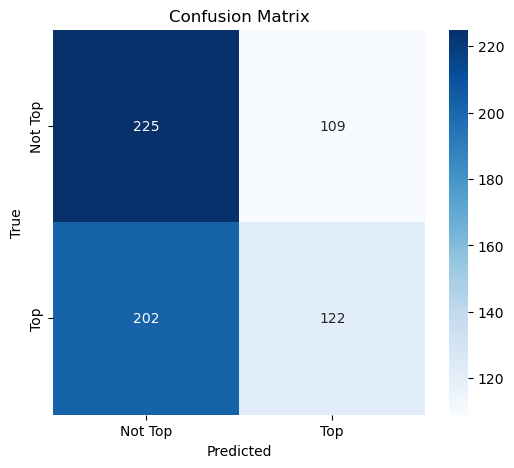

In [7]:
model, history = train_album_classifier(df, img_dir='../../album_images')

In [25]:
genres = pd.read_csv('../data/new/albums_with_final_genres.csv')
genres.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   artist_name      3289 non-null   object
 1   artist_id        3289 non-null   object
 2   genre            3289 non-null   object
 3   album_id         3289 non-null   object
 4   album_name       3289 non-null   object
 5   release_date     3289 non-null   object
 6   total_tracks     3289 non-null   int64 
 7   popularity       3289 non-null   int64 
 8   image_url        3289 non-null   object
 9   genre_condensed  3289 non-null   object
dtypes: int64(2), object(8)
memory usage: 257.1+ KB


In [26]:
genders = pd.read_csv('../data/new/artist_genders_more_women.csv')
genders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    860 non-null    object
 1   gender  860 non-null    object
dtypes: object(2)
memory usage: 13.6+ KB


In [27]:
df = df.merge(genders, how='left', left_on='artist_name', right_on='name')
df.drop(columns='name', inplace=True)  # remove the duplicate name column

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   artist_name   3289 non-null   object
 1   artist_id     3289 non-null   object
 2   genre         3289 non-null   object
 3   album_id      3289 non-null   object
 4   album_name    3289 non-null   object
 5   release_date  3289 non-null   object
 6   total_tracks  3289 non-null   int64 
 7   popularity    3289 non-null   int64 
 8   image_url     3289 non-null   object
 9   gender        3225 non-null   object
dtypes: int64(2), object(8)
memory usage: 257.1+ KB


In [29]:
# Again, dedupe genre info only
genres_deduped = genres[['album_id', 'genre_condensed']].drop_duplicates(subset='album_id')

# Merge with original df (even if df has duplicate album_ids, this will only expand if genre_deduped still has dups)
df = df.merge(genres_deduped, on='album_id', how='left')


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 0 to 3288
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   artist_name      3289 non-null   object
 1   artist_id        3289 non-null   object
 2   genre            3289 non-null   object
 3   album_id         3289 non-null   object
 4   album_name       3289 non-null   object
 5   release_date     3289 non-null   object
 6   total_tracks     3289 non-null   int64 
 7   popularity       3289 non-null   int64 
 8   image_url        3289 non-null   object
 9   gender           3225 non-null   object
 10  genre_condensed  3289 non-null   object
dtypes: int64(2), object(9)
memory usage: 282.8+ KB
